In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
import plotly.graph_objects as go

In [32]:
df = pd.read_csv("PCA_Customer_Data.csv")
df.head()

,CustomerID,PC1,PC2,PC3,PC4,PC5,PC6
0,12346.0,-2.659371,-1.636472,-0.543115,-0.054209,-0.114366,-1.988442
1,12347.0,3.780832,-1.479966,0.605603,-0.345088,-0.010899,0.721764
2,12350.0,-1.819527,-0.541717,0.965524,-1.310723,-0.606334,0.227094
3,12352.0,0.232564,-1.475126,-0.938797,-0.539464,-0.220370,0.484831
4,12353.0,-2.318130,0.519302,-0.257238,-1.407346,-0.810911,0.718952


c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: Futur

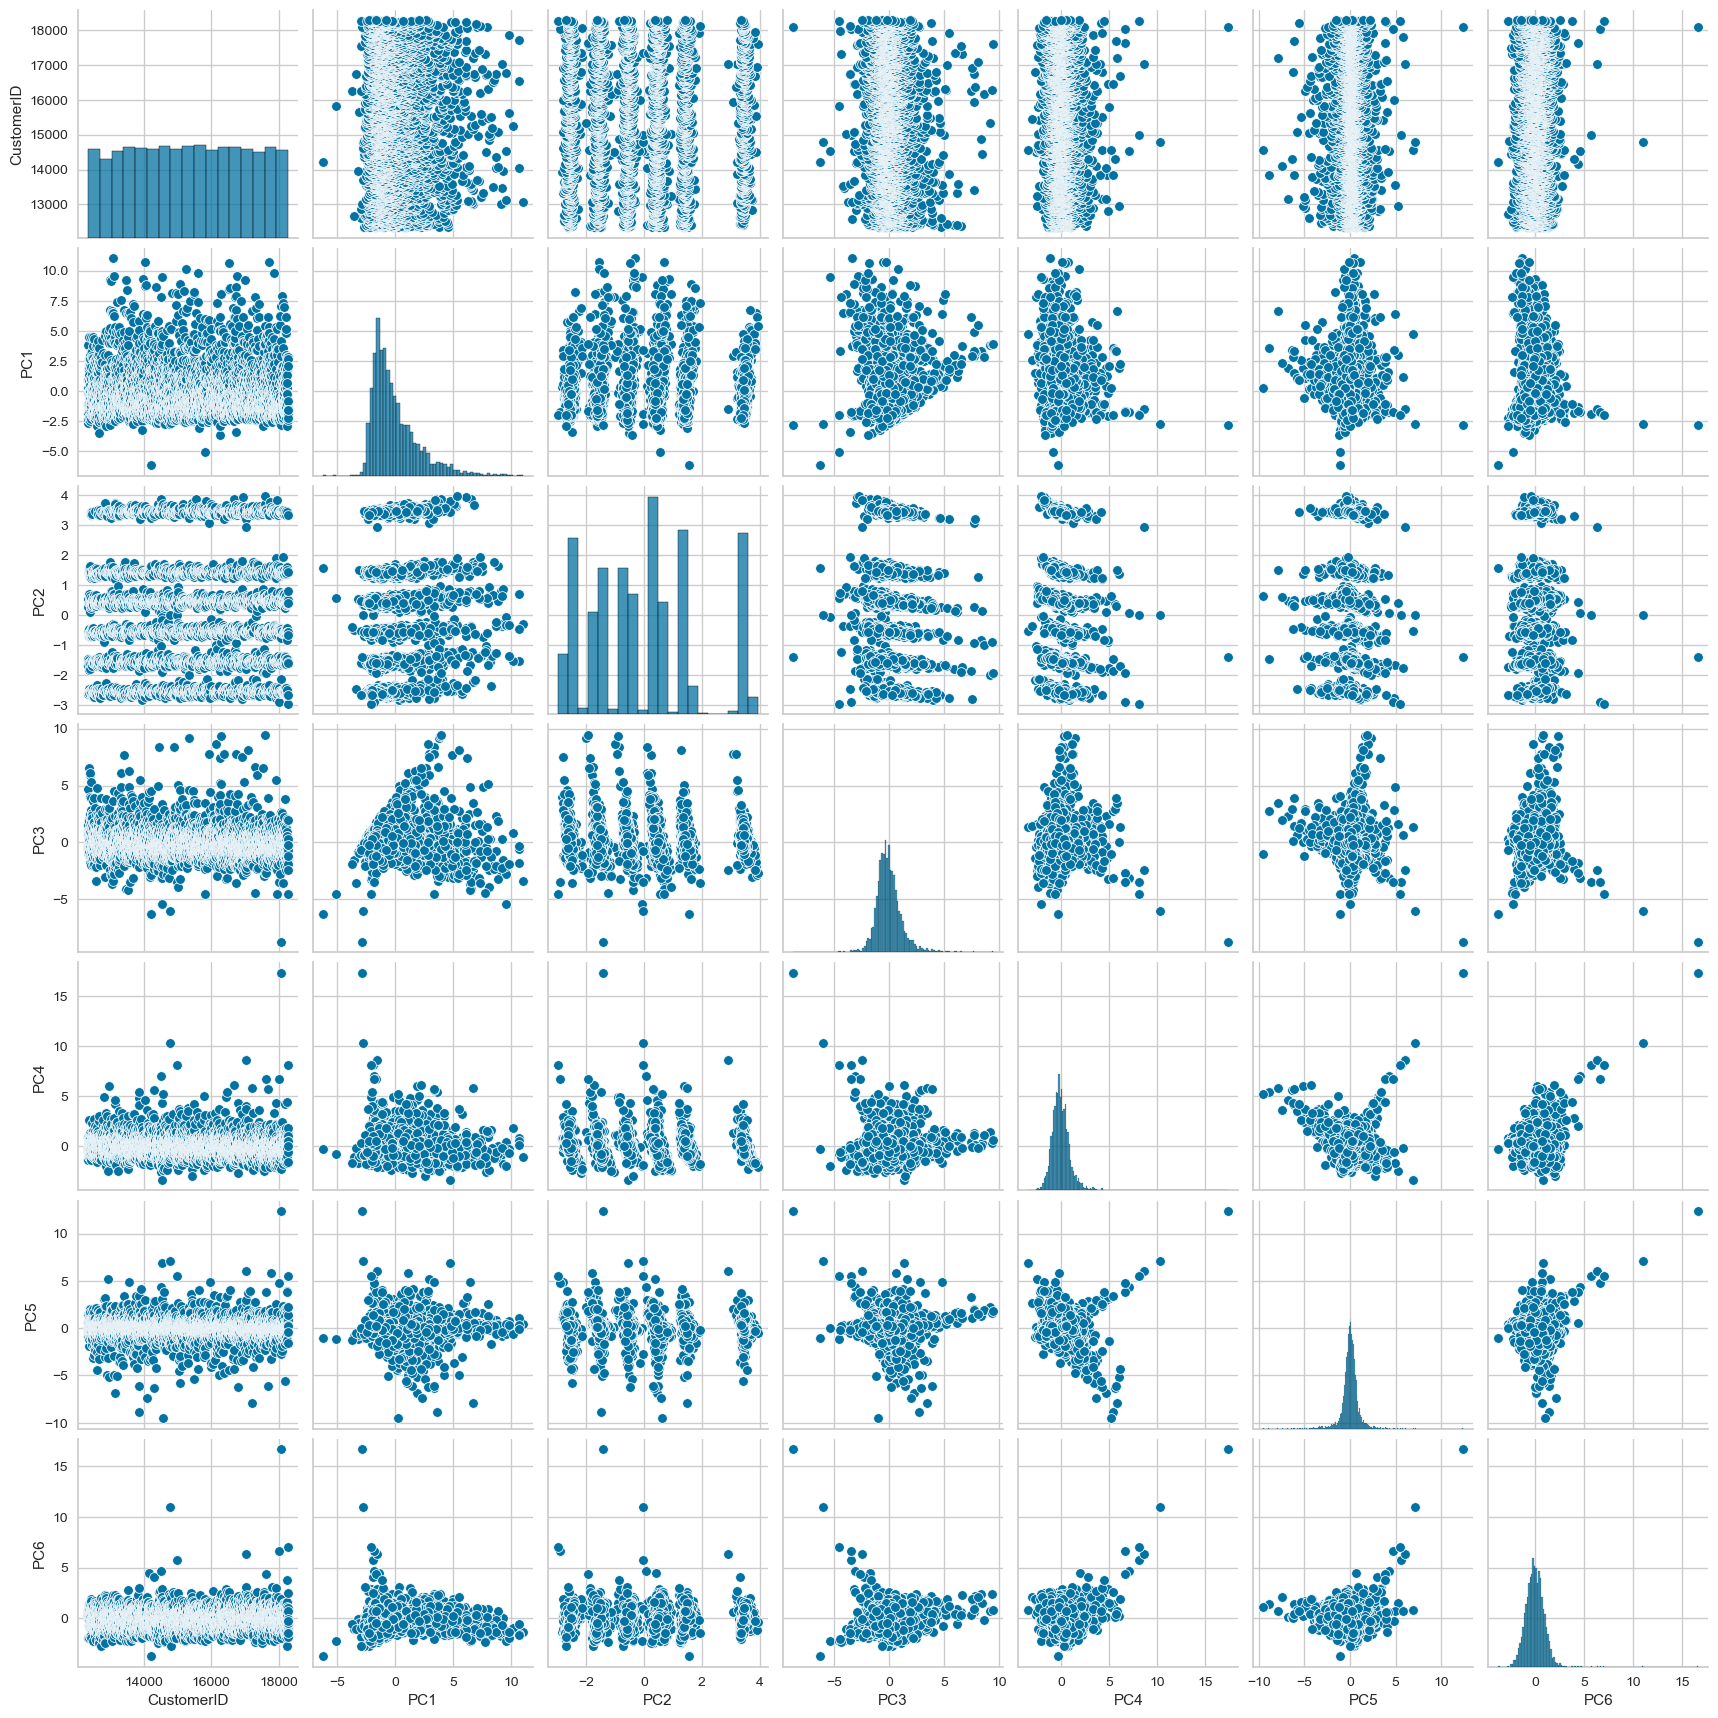

In [33]:
#Data Distribution

sns.pairplot(df)
plt.show()

## Elbow Method

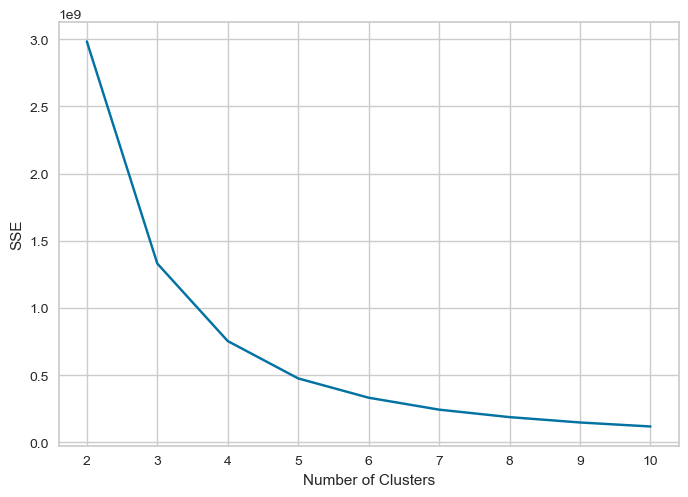

In [34]:
#kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}


sse = [] #sum of squared error list
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### It is observed that there is a strong bend at 7.

### Alternate Library for elbow method

In [35]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,1), metric='calinski_harabasz', timings=False
)
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show()        

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [36]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)
kmeans.fit(df)

KMeans(init='random', n_clusters=3, n_init=10, random_state=1)

In [39]:
# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 0, 1: 1, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels to the PCA version of the dataset
df['cluster'] = new_labels

In [40]:
df.head()

,CustomerID,PC1,PC2,PC3,PC4,PC5,PC6,cluster
0,12346.0,-2.659371,-1.636472,-0.543115,-0.054209,-0.114366,-1.988442,2
1,12347.0,3.780832,-1.479966,0.605603,-0.345088,-0.010899,0.721764,2
2,12350.0,-1.819527,-0.541717,0.965524,-1.310723,-0.606334,0.227094,2
3,12352.0,0.232564,-1.475126,-0.938797,-0.539464,-0.220370,0.484831,2
4,12353.0,-2.318130,0.519302,-0.257238,-1.407346,-0.810911,0.718952,2


Visualizing the Clusters

In [41]:
colors = ['#e8000b', '#1ac938', '#023eff']

# Create separate data frames for each cluster
cluster_0 = df[df['cluster'] == 0]
cluster_1 = df[df['cluster'] == 1]
cluster_2 = df[df['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

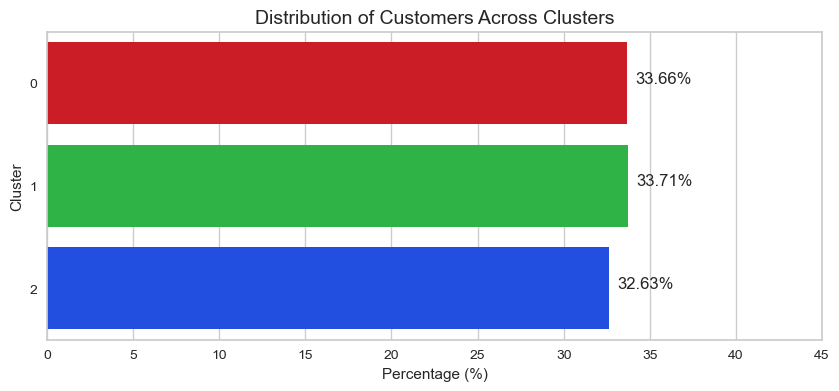

In [42]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (df['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()